In [ ]:
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha
!pip install 'tensorflow-hub == 0.5'

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.5.0
GPU is NOT AVAILABLE


In [48]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/drive/MyDrive/29042021 Rice Leaf Disease/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [49]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [50]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/drive/MyDrive/29042021 Rice Leaf Disease/rice/train : 157files
total images for validation : /content/drive/MyDrive/29042021 Rice Leaf Disease/rice/validation : 84files


In [51]:
import json

with open('/content/drive/MyDrive/29042021 Rice Leaf Disease/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [52]:
print('Number of classes:',len(classes))

Number of classes: 3


In [ ]:
module_selection = ("inception_v3", 299, 2048) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 

In [54]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    )

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [55]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [56]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [57]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [58]:
LEARNING_RATE = 0.001 

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [37]:
EPOCHS=30 

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/30
2/2 [==============================] - 31s 16s/step - loss: 1.8213 - accuracy: 0.4194 - val_loss: 3.1815 - val_accuracy: 0.0312
Epoch 2/30
2/2 [==============================] - 35s 17s/step - loss: 1.4670 - accuracy: 0.6016 - val_loss: 1.2414 - val_accuracy: 0.2500
Epoch 3/30
2/2 [==============================] - 29s 15s/step - loss: 0.6906 - accuracy: 0.6129 - val_loss: 0.5930 - val_accuracy: 0.7031
Epoch 4/30
2/2 [==============================] - 27s 13s/step - loss: 0.8232 - accuracy: 0.6559 - val_loss: 0.8628 - val_accuracy: 0.6719
Epoch 5/30
2/2 [==============================] - 35s 17s/step - loss: 0.4539 - accuracy: 0.8047 - val_loss: 1.1950 - val_accuracy: 0.5625
Epoch 6/30
2/2 [==============================] - 29s 15s/step - loss: 0.4310 - accuracy: 0.8172 - val_loss: 1.2721 - val_accuracy: 0.5781
Epoch 7/30
2/2 [==============================] - 27s 14s/step - loss: 0.4063 - accuracy: 0.8280 - val_loss: 1.0534 - val_accuracy: 0.5156
Epoch 8/30
2/2 [===========

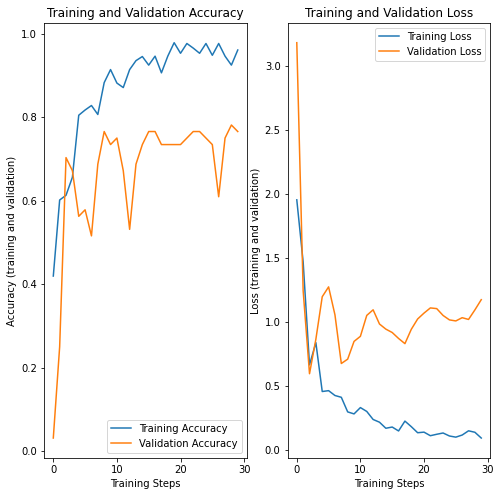

In [38]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [39]:
import cv2

import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_030.jpg
PREDICTED: class: brownspot, confidence: 0.723077


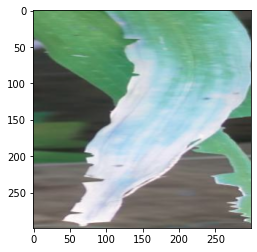

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_020.PNG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.634084


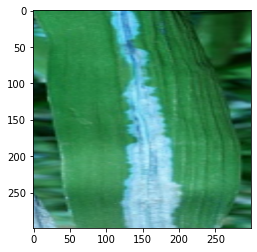

SOURCE: class: blast, file: blast/blast_rotated_019.jpg
PREDICTED: class: brownspot, confidence: 0.894922


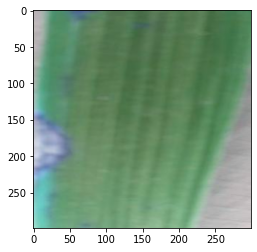

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_036.JPG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.988519


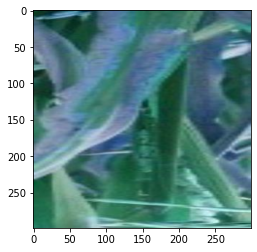

<Figure size 432x288 with 0 Axes>

SOURCE: class: brownspot, file: brownspot/brownspot_rotated_009.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.433745


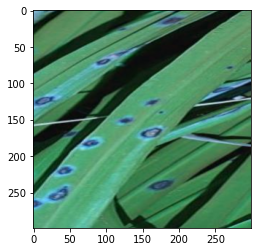

<Figure size 432x288 with 0 Axes>

In [40]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()